# UTMIST Eigen AI Conference Workshop: Demistifying Diffusion Models
Author: UTMIST TW + Academics Team

**What is this notebook about?**

In this Eigen AI workshop, we will go over some of the most fundamental ideas behind diffusion models, how they work and why they have been a major advancement in the field of computer vision and generative artifical intelligence. We hope that you can walk away capable of building your own diffusion model from scratch and understanding some of the core ideas that are trending in this field of research.

**What do I need to set up my environment?**

* **Python** as our core programming language
* **PyTorch** as a deep learning framework
* **Diffusers** as a diffusion model library to help speed up our experiments.
* Some additional libraries for obtaining datasets, helper functions etc.
  * torchvision, numpy, tqdm, PIL
  * eigenai-workshop github repo for some boiler plate code
  * a pretrained model checkpoint


**How is this notebook structured?**
* Section 1. Introduction to Deep learning & Generative Modelling
* Section 2. Overview of Neural Networks
* Section 3. Overview of Diffusion Models & How they work
* Section 4. Forward Diffusion Process
* Section 5. Rerverse Diffusion Process
* Section 6. The Role of a Noise Scheduler
* Section 7. Training of a diffusion model
* Section 8. Visualizing the inference results

In [ ]:
!git clone https://github.com/UTMIST/eigenai-workshop.git

Cloning into 'eigenai-workshop'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 103 (delta 5), reused 25 (delta 3), pack-reused 73 (from 1)
Receiving objects: 100% (103/103), 48.92 MiB | 23.89 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [ ]:
!pip install -q diffusers gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 37.2 MB/s eta 0:00:00


In [ ]:
# Download our pretrained model checkpoint
!gdown --fuzzy -q https://drive.google.com/file/d/187Jfn_-mXFlDauPLodu-PVb5A97hbaKP/view?usp=share_link

In [ ]:
# Lets import all the necessary packages
import os
import gdown
import torchvision # for handling image data within the PyTorch ecosystem.
from diffusers.utils import make_image_grid
from torchvision.transforms.functional import pil_to_tensor, to_pil_image # to convert images to PyTorch tensors and vice versa.
import torch # main PyTorch library for tensor operations and neural network modules.
import numpy as np # library for numerical operations with support for large, multi-dimensional arrays and matrices.
import ipywidgets as widgets # for creating interactive UI elements in Jupyter notebooks.
import torch.nn.functional as F
from ipywidgets import interact # a function to create interactive controls for Jupyter notebooks.
from tqdm import tqdm
from PIL import Image

In [ ]:
# We cloned the utmist-eigenai repo earlier
%cd /content/eigenai-workshop
from data import create_dataloader
from model import create_diffusion_model
from scheduler import create_noise_scheduler,create_ddpm_plot
from utils import forward_diffusion,create_default_config, create_accelerator, create_optimizer_and_lr_scheduler

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


/content/eigenai-workshop


0it [00:00, ?it/s]

# **Section 1: Introduction to Deep Learning & Generative Modelling**

### **What is deep learning?**

Deep learning is a branch of Machine Learning that specializes in the use of **artifical neural networks** to make predictions. The core idea of deep learning is to train computers (specifically neural networks) to recognize patterns from a lot of data. Using that generalization the algorithm learns to make intelligent decisions.

### **What is generative modelling?**

Generative modeling is a technique in machine learning that creates new data similar to what it was trained on. Instead of just predicting, these models generate new outputs, like new images or text, based on the patterns they’ve learned from existing data.


# **Section 2: Overview of Neural Networks**

**What is a neural network?**

A neural network is a computational model inspired by the way biological neural
networks in the brain work.


#### **Structure of a neural network**:
 A neural network is composed of multiple layers of individual neurons. We call an artifical neuron a 'perceptron'. Like a biological neuron, a perceptron receives some input or stimulus. We model the connection strength between neurons with a **weight** and a **bias**. We then perform a **weighted sum** of the inputs with the weights and biases. Lastly we apply a non-linear function to determine whether it should 'activate' or 'fire'. in order to form the ouput.

 <center>
<a href="https://ibb.co/ZxwJfq1"><img src="https://i.ibb.co/bXy36cR/perceptron.jpg" alt="perceptron" border="0"></a><br /><a target='_blank' href='https://imgbb.com/'></a><p>A diagram of a perceptron</p>
 </center>

 We represent the operations of a perceptron by this equation: $y = \sigma(wx +b)$, where:


*   **x**: input data or vector
*   **w**: weight vector
*   **b**: bias vector
*   **$\sigma()$**: non-linear activation function
*   **y**: output vector


If we zoom out a bit, the full neural network is simply a chain of a bunch of these 'perceptrons' put together in a layer and we stack multiple layers of these 'perceptrons' to form our model. We call the layer that processes our input data the **input layer** and the intermediate layer(s) **hidden layer(s)**. The final layer that produces our output is called the **output layer**. The output of a neural network is also called the prediction.

<center>
<a href="https://ibb.co/tJrjHVK"><img src="https://i.ibb.co/sVYxg8R/neural-network.png" alt="neural-network" border="0"></a><br /><a target='_blank' href='https://imgbb.com/'></a><p>A diagram of a neural network (Source: https://www.v7labs.com/blog/neural-network-architectures-guide)</p></center>


#### **Training of a neural network**:
The goal of deep learning is to allow these artifical neural networks to learn patterns from a lot of data. To do so, we pass some **input** into our neural network. The **weights and biases** of the perceptrons in the model process the data, perform computations on it to arrive at some **output** (prediction). In order to **train** these neural networks, we need to:

**a) Compute the loss:** Inform the model on how wrong their prediction was compared to the ground truth\
**b) Perform backpropagation and weight updates:** Tell the neural network to make the right corrections

In **step a**, we compute a value called a **loss $L$** , representing how far or how different your prediction was from your ground truth, using a **loss function**. The choice of your loss function can very well depend on your problem setting and the data you are trying to predict.

In **step b**, we use an algorithm called **backpropagation** to find the gradients with respect to this loss value $\frac{\partial{L}}{\partial{\theta}}$ for all the weights and biases in our neural network. Then the gradients tell us how much we should update the weights such that we minimize the loss the most.


> **Intuition behind BackPropagation**
>
> <a href="https://ibb.co/jWXWMQR"><img src="https://i.ibb.co/jWXWMQR/loss-landscape.png" alt="loss-landscape" border="0"></a> \\
> We can think of the training process of a neural network as traversing this loss surface.
> Imagine you had just 3 numbers $x,y,z$ representing the weights and biases of your model.
>
> Every point you stand on this surface, you would get some output value $L(x,y,z)$. This basically means that if my weights were $x_0,y_0,z_0$, I would have a loss value of $L_0$. \\
> Backpropagation tells you which **direction** you should move on this surface so that you get **closer** and **closer** to a **global minimum**.
>
> Each iteration of backpropagation results in a **gradient update** that changes where you are on the surface.


# **Section 3: Overview of Diffusion models**

**What are diffusion models?**

If you have ever used DALLE from OpenAI or Stable Diffusion. It lets you type in a text prompt and it tries to **generate** an image that suits your liking. But have you ever wondered what happens when you press generate ? (You probably have or you wouldn't be reading this lol)

These generative artificial intelligence applications rely on diffusion models. The idea of diffusion models originally came from non-equilibirum thermodynamics. Diffusion models are also built upon the work of [Variational AutoEncoders](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73) as well as [Geneartive Adversarial Networks](https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29) (GANs), both of which have been a main advance in image synthesis and image generation.
. Diffusion models leverage neural networks to learn from a lot of data. Let's see a bit more in depth on how they work.



**The Diffusion Process**

Diffusion models are deep neural networks that learn to take some noisy input and denoise it into something meaningful.


<center>
<a href="https://ibb.co/Kw77Vny"><img src="https://i.ibb.co/DpkkwdK/Screenshot-2024-05-06-005141.png" alt="Screenshot-2024-05-06-005141" border="0"></a>
</center>  

Imagine that there is a distribution that describes your dataset of images

You can also think of it as your classic probability example: \\
Imagine that you have an urn. You put your hand in there and you pull out a ball. Each ball represents a different image.

To describe it in a more **specific** way, diffusion models aim to **sample** from this data distribution in a flexible way to produce some output that is sensible.



The diffusion process has 2 parts. The forward process that injects noise and the reverse process that removes noise from an image. Let's see how each work. We describe it as a **process** because we can think of diffusion happening over time. We say that the injection and removal of noise is a process that happens over time. At different points in time (different timesteps), we are doing something different to our image.

In this workshop, we will mostly work with the MNIST dataset, a dataset of handwritten digits and we will try to train a model that generates images of handwritten digits! We will see how to load the images in and train a model on MNIST to generate similar images.

# **Section 4: Forward Diffusion Process**

**What is the forward process?**

In the forward process (we denote the forward process as **$q$**),we have a series of steps in the forward process. Each step **indicates** us adding Gaussian noise to the original image or signal.

We repeat this process of adding noise **iteratively** until we reach pure Gaussian noise.

For example if I had 1000 diffusion steps, that means I am going to add noise to my original image 1000 times. Think of a timeline where at time $T = 0$, the image is the cleanest. And at time $T = 1000$. It would be **completely noisy**.

[![Foo](https://www.assemblyai.com/blog/content/images/2022/05/image.png)](http://google.com.au/)

<center>Figure from <a href="https://arxiv.org/pdf/2006.11239">DDPM paper</a>
</center>


We can think about the forward process as a **linear combination** of the signal and the noise. In simpler words, we are just doing a **weighted sum** of the image and noise.

We can represent the forward process with this equation.
$$
x_t = \alpha_t x_{t-1} + \sigma_t \epsilon
$$

* $x_t$ : represents the signal after one forward step
* $x_{t-1}$ : represents the signal from the previous timestep along the diffusion process
*   $\alpha_t$ coefficient: the portion of the signal we want to preserve **at timestep $t$**
*   $\sigma_t$ coefficient: the portion of noise we want to add to the signal **at timestep $t$**
* $\epsilon$ : represents the noise vector sampled from a Gaussian Distribution

> This equation just means the signal at time $t$ is going to contain
> **some portion of the signal** at time $t-1$ and **some portion of noise**


In [ ]:
dataset = torchvision.datasets.MNIST(root="/content/sample_data",download=True)
print(len(dataset)) #See the length of the dataset

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17705496.83it/s]


Extracting /content/sample_data/MNIST/raw/train-images-idx3-ubyte.gz to /content/sample_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 484221.25it/s]


Extracting /content/sample_data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/sample_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4368064.75it/s]


Extracting /content/sample_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/sample_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9229907.35it/s]

Extracting /content/sample_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/sample_data/MNIST/raw

60000


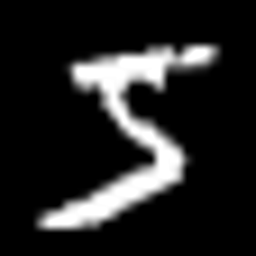

This is an image of a 5 - five!


In [ ]:
# Lets look at one of the images from the dataset!
x = (dataset[0][0].resize((256,256)))
display(x)
print(f"This is an image of a {dataset.classes[dataset[0][1]]}!")

In [ ]:
# Helper functions: Lets make some normalization functions
# these functions normalize the images to have pixel values between -.5 to .5

norm = lambda x:((x.float() + 255)/510) -0.5         # Function to normalize image tensor values to range [-0.5, 0.5]
denorm = lambda x: ((x+0.5)*510-255).to(torch.uint8) # Function to denormalize image tensor values back to the original range [0, 255]

# What if we try simulating the forward process?
x_0 = norm(pil_to_tensor(x)) # take the image, turn it into a tensor and normalize it
noise = torch.randn(256,256) # lets sample some noise from a gaussian distribution

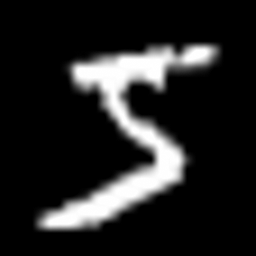

In [ ]:
# For our 1st iteration of forward diffusion,
# lets say I want the image to be 99.99% original image, 0.01% noise
α_1  = 0.9999 # α_t=1
σ_1 = 0.0001 # σ_t=1
x_1 = α_1*x_0 + σ_1*noise
display(to_pil_image(denorm(x_1)))

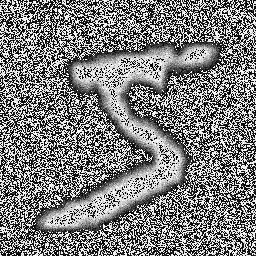

In [ ]:
# For our 2nd iteration of, we take x_1 (the one we just added noise to)
# and apply another forward step, so x_t-1 = x_1
α_2 = 0.95 # α_t=2
σ_2 = 0.05 # σ_t=2
x_2 = α_2*x_1 + σ_2*noise
display(to_pil_image(denorm(x_2)))

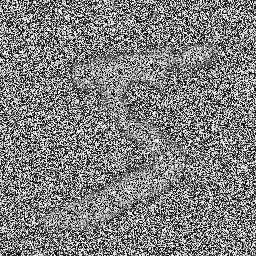

In [ ]:
# For our 3rd iteration, we take x_2 and apply another forward step (*)
α_3 = 0.91 # α_t=3
σ_3 = 0.09 # σ_t=3
x_3 = α_3*x_2 + σ_3*noise
display(to_pil_image(denorm(x_3)))

If we keep doing that, we would eventually get to a point where the image becomes complete noise (Pure Gaussian)!

But it seems kind of tideous that in order to add some noise we always depend on the previous step and that would mean it would take forever if I wanted to inject noise into the image step by step.

> **Why can't we just inject a bunch of noise to the model all at once, so we don't need to inject noise 1000 times over and over again?**
>
> We can, buttt this would **immediately** destroy all the visual structure in the image. This would make it very hard for the model to reconstruct the original image.
> Thus, we want our model to gradually reverse the addition of noise
> and we want this reverse process to be more progressive (bit by bit)
> That is more stable for the model to learn.



> **A helpful analogy for understanding the importance of gradual injection/removal of noise:** \\
> Imagine you have 2 children and your children named Andrew and Mathew went off to school so you are trying to clean their rooms.
> Mathew left the room in total chaos while one made quite a mess but its still okay.
>  
(DISCLAIMER: these are images taken online, it does not reflect the state of anybody's room, definitely not any Andrew's or Mathew's we know)

**Andrew's Room: a little messy but you sort of know where things are, how to put things back in order**

<a href="https://ibb.co/gR8k5Mq"><img src="https://i.ibb.co/z4gqyh9/messy-room.jpg" alt="messy-room"></a>

**Mathew's Room: you don't even know where to start organizing!**

<a href="https://imgbb.com/"><img src="https://i.ibb.co/xM1jJ9P/very-messy-room.jpg" alt="very-messy-room" border="0" /></a>

You can clearly see that your life would be so much easier if your children are not super chaotic with their activities in their room or if their messiness is very gradual (Maybe they forget to put some clothes back, left some books lying around, the gradual messiness that was introduced to their room is still manageable and you have a good sense of how to revert it to a tidy state).

Now, imagine if the room was thrown into complete chaos—the furniture is overturned, items are scattered randomly, and it’s impossible to tell where anything belongs. In this chaotic state, you have no sense of the original structure of the room. Trying to organize it from such a mess would be extremely difficult because you don’t have any reference point to begin with.


This exact intuition applies to diffusion models
* Gradual noise injection (gradual noise removal) lets you still make sense of the structure of the image. Each gradual step is very useful in telling us how pixels should be arranged.
* A chaotic mess (injecting noise all at once) leads to total disorganization, it is really hard for us to revert back to its original state. Its almost impossible to recover any meaningful structure if we just added random noise all at once.

I left a code block here just to show how you can rewrite the iterative process in closed form (so basically instead of applying the ).

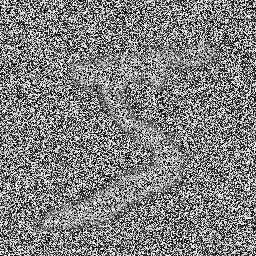

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]])

In [ ]:
# @title
# Realization💡: wait so can we rewrite x_3 in terms of x_0?
# Yes we can actually!

alpha_1  = 0.9999 # alpha_t=1
sigma_1 = 0.0001 # sigma_t=1
alpha_2 = 0.95 # alpha_t=2
sigma_2 = 0.05 # sigma_t=2
alpha_3 = 0.91 # alpha_t=3
sigma_3 = 0.09 # sigma_t=3

x_3 = alpha_3 * ( alpha_2 * (alpha_1 * x_0 + sigma_1 * noise) + sigma_2 * noise) + sigma_3* noise
x_3 = alpha_3 * ( alpha_2 * alpha_1 * x_0 + alpha_2 * sigma_1 * noise + sigma_2 * noise) + sigma_3* noise
x_3 = alpha_3 * alpha_2 * alpha_1 * x_0 + alpha_3 * alpha_2 * sigma_1 * noise + alpha_3 * sigma_2 * noise + sigma_3* noise

total_noise = alpha_3 * alpha_2 * sigma_1 * noise + alpha_3 * sigma_2 * noise + sigma_3* noise
total_noise = noise * (alpha_3 * alpha_2 * sigma_1 + alpha_3 * sigma_2 + sigma_3)
#                     |---------------------------------------------------------|


# If we do some simplification on this noise coefficient...
# alpha_3 * alpha_2 * (1 - alpha_1) + (alpha_3 * (1 - alpha_2) + (1 - alpha_3) )
# (alpha_3 * alpha_2) - (alpha_3 * alpha_2 * alpha_1) + alpha_3 - (alpha_3 * alpha_2) + 1 - alpha_3
# 1 - (alpha_3 * alpha_2 * alpha_1) [Hey we didnt need any sigma terms !]

# From this we can directly uses x_0 to get to x_3
x_3 = alpha_3 * alpha_2 * alpha_1 * x_0 + (1 - (alpha_3 * alpha_2 * alpha_1))*noise
display(to_pil_image(denorm(x_3)))

# Lets just check that they are the same with the iterative version using x_t-1 (*)
np.isclose(alpha_3*x_2 + sigma_3*noise,x_3)

#### **Let's write everything in a nicer form**

There is actually a way for us to represent the gradual injection of noise to the signal in one closed-form.

$$
x_t = \sqrt{\bar{\alpha_t}} x_0 + \sqrt{(1 - \bar{\alpha_t})} \epsilon
$$

* $\bar{\alpha_t} = Π_{s=1}^{t} \alpha_s$: represents a constant weighting applied to the original signal
* $\alpha_s = 1 - \beta_s$
* $\beta_s$: this is a linear function that monotonically increases with t
* $x_0$: represents the original clean image
* $\epsilon$: represents the noise we are adding to the original signal

NOTE: writing the forward process in closed form is equivalent to you doing it gradually, this just helps speed up our computation and we dont need to write out long long equations. But this is NOT the same as adding noise in one go.

> If you are confused by what all this math means 😭 \\
> Don't worry bear with me!
> this formula just tells us for the signal at diffusin timestep $t$ ,
> what portion (controlled by $\sqrt{\bar{\alpha_t}}$) of the original signal is kept and what portion of noise (controlled by $\sqrt{(1 - \bar{\alpha_t})}$) is injected \\
> The beta function $\beta_t$ tells us how does the noise term grow over time (linearly)


### **Play with the slider to see how forward diffusion injects noise into this beautiful picture of our UTMIST Co-President Mathew!**

In [ ]:
# @title

# Import libraries
import torch
import numpy as np
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

# Enable interactive widgets in Colab
from google.colab import widgets as colab_widgets

# Define normalization and denormalization functions
def norm(img):
    """
    Normalize image to [-1, 1]
    Args:
        img (torch.Tensor): Image tensor with values in [0, 1]
    Returns:
        torch.Tensor: Normalized image tensor with values in [-1, 1]
    """
    return (img - 0.5) * 2

def denorm(img):
    """
    Denormalize image back to [0, 1]
    Args:
        img (torch.Tensor): Normalized image tensor with values in [-1, 1]
    Returns:
        torch.Tensor: Denormalized image tensor with values in [0, 1]
    """
    return (img + 1) * 0.5

# Define the noise schedules
def create_noise_schedules(T=1000, beta_start=1e-4, beta_end=2e-2):
    """
    Create beta, alpha, and cumulative alpha schedules for DDPM
    Args:
        T (int): Total number of timesteps
        beta_start (float): Starting value of beta
        beta_end (float): Ending value of beta
    Returns:
        tuple: (sqrt_alphas_bar, sqrt_one_minus_alphas_bar)
    """
    betas = np.linspace(beta_start, beta_end, T, dtype=np.float64)
    alphas = 1.0 - betas
    alphas_cumprod = np.cumprod(alphas)

    # Convert to torch tensors
    sqrt_alphas_bar = torch.tensor(np.sqrt(alphas_cumprod), dtype=torch.float32)
    sqrt_one_minus_alphas_bar = torch.tensor(np.sqrt(1.0 - alphas_cumprod), dtype=torch.float32)

    return sqrt_alphas_bar, sqrt_one_minus_alphas_bar

# Load and prepare the image
def load_image(image_path):
    """
    Load an image from the given path and convert it to a normalized tensor
    Args:
        image_path (str): Path to the image file
    Returns:
        torch.Tensor: Normalized image tensor
        PIL.Image.Image: Original PIL image
    """
    pil_img = Image.open(image_path).convert("RGB").resize((256,256))  # Ensure it's in RGB
    to_tensor = ToTensor()
    to_pil_image = ToPILImage()

    x_0 = to_tensor(pil_img)  # Shape: [3, H, W]
    x_0 = norm(x_0)            # Normalize to [-1, 1]

    return x_0, pil_img

# Generate noise
def generate_noise(x_0):
    """
    Generate Gaussian noise with the same shape as the input tensor
    Args:
        x_0 (torch.Tensor): Normalized image tensor
    Returns:
        torch.Tensor: Gaussian noise tensor
    """
    noise = torch.randn_like(x_0)  # Shape: [3, H, W]
    return noise

# Define the forward diffusion function
def forward_diffusion(x_0, noise, sqrt_alphas_bar, sqrt_one_minus_alphas_bar, to_pil_image):
    """
    Define the forward diffusion process with an interactive slider
    Args:
        x_0 (torch.Tensor): Normalized original image tensor
        noise (torch.Tensor): Gaussian noise tensor
        sqrt_alphas_bar (torch.Tensor): Precomputed sqrt(alphas_bar)
        sqrt_one_minus_alphas_bar (torch.Tensor): Precomputed sqrt(1 - alphas_bar)
        to_pil_image (function): Function to convert tensor to PIL image
    """
    T = len(sqrt_alphas_bar)

    def forward(timestep: int):
        '''
        Runs the forward diffusion process and displays the noise-injected signal at time t
        Args:
            timestep (int): Current timestep in the diffusion process
        '''
        if timestep < 0 or timestep >= T:
            raise ValueError(f"Timestep should be in [0, {T-1}], got {timestep}")

        # Get the scaling factors for the current timestep
        sqrt_alpha_bar = sqrt_alphas_bar[timestep]
        sqrt_one_minus_alpha_bar = sqrt_one_minus_alphas_bar[timestep]

        # Apply the forward diffusion step
        x_t = sqrt_alpha_bar * x_0 + sqrt_one_minus_alpha_bar * noise
        x_t = torch.clamp(x_t, -1.0, 1.0)  # Ensure values are within [-1, 1]

        # Denormalize and convert back to PIL image
        pil_x_t = to_pil_image(denorm(x_t).cpu())

        # Display the image
        display(pil_x_t)

    # Create interactive slider
    widgets.interact(forward, timestep=widgets.IntSlider(min=0, max=T-1, step=1, value=0))

# Main function to tie everything together
def apply_forward_diffusion(image_path="/content/eigenai-workshop/mathew.png"):
    """
    Apply the forward diffusion process to an image and visualize it with a slider
    Args:
        image_path (str): Path to the PNG image file
    """
    # Step 1: Create noise schedules
    sqrt_alphas_bar, sqrt_one_minus_alphas_bar = create_noise_schedules()

    # Step 2: Load and normalize the image
    x_0, pil_img = load_image(image_path)

    # Debugging: Check normalization
    print(f"x_0 range: {x_0.min().item()} to {x_0.max().item()}")  # Should be [-1.0, 1.0]

    # Step 3: Generate noise
    noise = generate_noise(x_0)

    # Debugging: Check noise statistics
    print(f"Noise mean: {noise.mean().item():.4f}, std: {noise.std().item():.4f}")  # ~0.0, ~1.0

    # Step 4: Initialize the image display function
    to_pil_image = ToPILImage()

    # Step 5: Define and display the forward diffusion process
    forward_diffusion(x_0, noise, sqrt_alphas_bar, sqrt_one_minus_alphas_bar, to_pil_image)

# Usage Example
# Replace 'your_image.png' with the path to your PNG image
# If using Google Colab, you can upload the image first

apply_forward_diffusion()


x_0 range: -1.0 to 1.0
Noise mean: -0.0011, std: 1.0025


interactive(children=(IntSlider(value=0, description='timestep', max=999), Output()), _dom_classes=('widget-in…

# **Section 5: Reverse Diffusion Process**

In the reverse process (we denote the reverse process as **$p$**), we want to structurally remove noise until we uncover the original data distribution. The reverse process is also called the **sampling or generation or denoising process**, and the method we use to perform the sampling is called the **sampler**. There have been many many sampling methods being developed to improve diffusion models, this notebook will cover only DDPM (Denoising Diffusion Probabilistic Models).

We start at $p(x_T) \sim \mathcal{N}(x_T,0,I)$, and sample a noisy signal $x_T$.
In order to reverse the process, we need to obtain the reverse Gaussian transitions $q(x_{t-1}|x_t)$. **However...** we cannot directly calculate  $q(x_{t-1}|x_t)$ as it is **intractable**, becuase we need to integrate over the entire dataset to obtain $q(x_{t-1})$ or $q(x_t)$

<center>
<img src="https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM.png" width=800 height=300></img>
</center>
<center>
Figure
</center>


For these reasons, we attempt to approximate the conditional probability distribution $q(x_{t-1}|x_t)$ with a neural network: $q_{\theta}(x_{t-1}|x_t)$ parametrized by model parameters $\theta$. More specifically:

**In probability form, the reverse process is:**

$$
p_{\theta} = p(x_T)\Pi_{t=1}^{T} p_{\theta}(x_{t-1}|x_t)
$$
We can expand this as: (cuz the authors were lazy)
$$
p_{\theta}(x_{0:T}) = p_{\theta}(x_{0}|x_1)p_{\theta}(x_{1}|x_2)p_{\theta}(x_{2}|x_3)p_{\theta}(x_{3}|x_4)p_{\theta}(x_{4}|x_5)\cdots p(x_T)
$$

**where the reverse conditional probabilities are:**
$$
p_{\theta}(x_{t-1}|x_t) = \mathcal{N}(x_{t-1},\mu_\theta(x_t,t),\Sigma_\theta(x_t,t))
$$

Given the signal $x_t$ that is at timestep $t$ of the diffusion process, we wish to use a neural network to predict $x_{t-1}$ that has mean $\mu_\theta$ and the variance $\Sigma_\theta$. (We are essentially predicting the conditional probability of $x_{t-1}$ given $x_t$)

**We can also write this in reparametrized form like this:**
$$
x_{t-1} = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha_t}}} \epsilon_\theta(x_t,t)) + \sigma_t z$$

> Let me break this equation down for you! \\
> $x_t$ represents the noisy signal at diffusion timestep t \\
> $\frac{\beta_t}{\sqrt{1 - \bar{\alpha_t}}} \epsilon_\theta(x_t,t)$ represents the amount of noise predicted by the neural network.
> $(x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha_t}}} \epsilon_\theta(x_t,t))$ this term tells us what is the predicted original signal (kind of like predicted $x_0$)


**Long story short:**

In the reverse process, we sample pure random Gaussian noise . We then **iteratively** remove noise using a neural network parametrized by $\theta$ to predict the amount of noise added to the original signal in the forward process at a certain diffusion timestep.

We repeat this process of predicting the noise, removing the noise on itself over and over again until we recover the original signal or something that looks sensible.



# **Section 6: The idea of a noise scheduler**



### Sampler : Denoising Diffusion Probabilistic Models (DDPM) Scheduler

The scheduler in DDPMs orchestrates the **noise addition** and **removal** process across multiple time steps. It defines how noise is incrementally injected into the data during the forward (diffusion) process and how it’s systematically removed during the reverse (denoising) process.

**Forward Process:**
$$
x_t = \sqrt{\bar{\alpha_t}} x_0 + \sqrt{(1 - \bar{\alpha_t})} \epsilon
$$

You can see that there are 2 terms $\bar{\alpha_t}$ and $(1-\bar{\alpha_t})$ are coefficients in front of the signal and the noise.

**Reverse Process:**
$$
x_{t-1} = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha_t}}} \epsilon_\theta(x_t,t)) + \sigma_t z$$

These 2 equations tell us exactly how noise is added and removed from the signal at each step of the diffusion process. And you can see that the amount of noise and signal is always controlled by the $\beta_t$ schedule, which influences $\alpha_t$, which influences $\bar{\alpha_t}$.



 **Key Roles of the Scheduler:**

1. **Noise Schedule Definition**: Determines the amount of noise added at each step.
2. **Variance Control**: Manages the variance of the noise at each step to ensure stability.
3. **Step Transition Management**: Coordinates the progression from one time step to the next in both forward and reverse processes.



## **Types of Noise Schedules**

There are many different types of noise schedulers that state-of-the-art models have explored. This changes how does $\beta_t$ change over time. But for this workshop, we **only** consider the linear case.

1. **Linear Schedule**: $\beta_t$ increases linearly from a small value to a larger one over \(T\) steps.
2. **Cosine Schedule**:  Uses a cosine function to vary, providing smoother transitions.

3. **Quadratic and Other Non-Linear Schedules**: variations that adjust the rate of noise addition in non-linear ways to optimize performance.


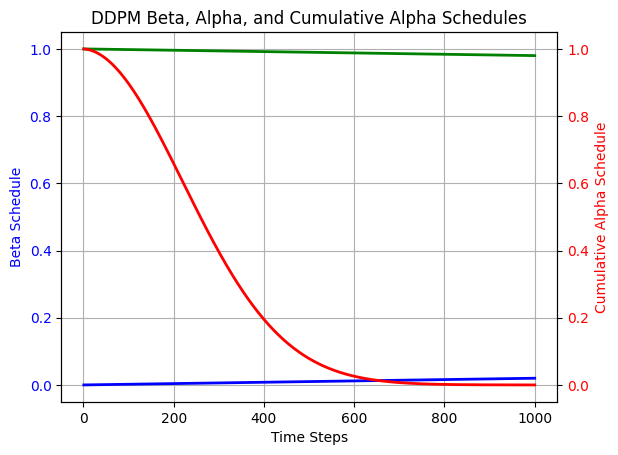

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_ddpm():
  # Simulated data for DDPM schedules
  T = 1000  # Total steps
  steps = np.arange(1, T + 1)

  # Beta schedule (linear)
  beta_schedule = np.linspace(0.0001, 0.02, T)

  # Alpha schedule
  alpha_schedule = 1 - beta_schedule

  # Cumulative alpha schedule
  alpha_cumprod_schedule = np.cumprod(alpha_schedule)

  # Call the plot helper function
  create_ddpm_plot(steps, beta_schedule, alpha_schedule, alpha_cumprod_schedule)

plot_ddpm()


### **Lets write the reverse/sampling process!**

We are going to take a pretrained model and try to run the reverse process on it.

In [ ]:
config = create_default_config()
print(config)

TrainingConfig()


In [ ]:
# Lets load pretrained weights into our model definition
state_dict = torch.load("/content/mnist-dm-checkpoint.pt",map_location=torch.device('cpu'))
model = create_diffusion_model(config)
model.load_state_dict(state_dict)
model = model.to("cuda") if torch.cuda.is_available() else model.to("cpu")

# We create a noise scheduler (DDPM)
scheduler = create_noise_scheduler(config)

<ipython-input-17-f372781841a9>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/content/mnist-dm-checkpoint.pt",map_location=torch.device('cpu'))


In [ ]:
# We can see the differnet blocks and layers inside the our U-Net neural network
model

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Con

In [ ]:
scheduler

NameError: name 'scheduler' is not defined

In [ ]:
# We will write a function called denosing_process
def denoising_process(config,model,scheduler,save_images = True,image_name="sample"):
    with torch.no_grad():
      # this step we sample some noise from a normal distriibution
      image = torch.randn(config.train_batch_size,model.config.in_channels, config.image_size, config.image_size).to(model.device)
      # 16, 3, 256, 256
      # loop through all the timesteps
      # start from 1000 (meaning pure noise)
      for t in tqdm(scheduler.timesteps):
        # pass pure noise to the model
          model_output = model(image,t).sample
          # model_output :how much noise to remove at this timestep
          image = scheduler.step(model_output,t,image).prev_sample
          # image is now the removed noise of that timstep
      # the final denoised image, perform some normalization
      image = (image / 2 + 0.5).clamp(0, 1)
      # 16, 256 256, 3
      image = image.cpu().permute(0, 2, 3, 1).numpy()
      # we convert to a range btw  0 -255
      images = (image * 255).round().astype("uint8")
      pil_images = [Image.fromarray(image) for image in images]
      if save_images:
          image_grid = make_image_grid(pil_images,rows=4,cols=4)
          image_grid.save(f"{image_name}.png")

denoising_process(config,model,scheduler,save_images=True,image_name="generation-sample")

100%|██████████| 1000/1000 [06:30<00:00,  2.56it/s]


[<PIL.Image.Image image mode=RGB size=128x128>,
 <PIL.Image.Image image mode=RGB size=128x128>,
 <PIL.Image.Image image mode=RGB size=128x128>,
 <PIL.Image.Image image mode=RGB size=128x128>,
 <PIL.Image.Image image mode=RGB size=128x128>,
 <PIL.Image.Image image mode=RGB size=128x128>,
 <PIL.Image.Image image mode=RGB size=128x128>,
 <PIL.Image.Image image mode=RGB size=128x128>,
 <PIL.Image.Image image mode=RGB size=128x128>,
 <PIL.Image.Image image mode=RGB size=128x128>,
 <PIL.Image.Image image mode=RGB size=128x128>,
 <PIL.Image.Image image mode=RGB size=128x128>,
 <PIL.Image.Image image mode=RGB size=128x128>,
 <PIL.Image.Image image mode=RGB size=128x128>,
 <PIL.Image.Image image mode=RGB size=128x128>,
 <PIL.Image.Image image mode=RGB size=128x128>]

# **Section 7: The Model Architecture**

Within the diffusion model literature, there are different popular model architectures that are used. Mainly in this workshop we will talk about the U-Net, which is a type of neural network specifically really good at analyzing images.

Its called a U-Net because of how the layers are structured (Looks like a U-shape). U-Net's have a series of convolutional neural network layers, a type of neural network that is really good at recognizing local patterns and features from the input.

Overall U-Net is a large convolutional neural network with a series of
residual blocks. Within each block there are convolutional layers as well as upsample or downsample blocks to reduce the dimensionality of the input signal.


<center>
<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width=450 height=300 >
</img>
</center>

<center>
Figure of a U-Net diagram
</center>

Properties of U-Net
* It has residual blocks, which contain residual connections that aim to learn the identity function $y = f(x) + x$ within each
* Upsample and downsample blocks that enlarge the signal or reduce the dimensionality of the signal
* Concatenation of the signal to later layers
* In [latent diffusion models](https://arxiv.org/pdf/2112.10752) (the work that later became stabel diffusion), they also had multi-head self attention and cross attention blocks inside the U-Net, most U-Nets after that use attention blocks.



In [ ]:
model = create_diffusion_model(create_default_config())
print(model)

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Con

# **Section 8: How do we train a diffusion model**


**Final training objective**:
Our final training objective tells us how are we going to teach the diffusion model (U-Net) to predict the same amount of noise that we applied during forward diffusion.

1. We first apply forward diffusion on our original image
2. We then pass the noisified image to the neural network
3. The neural network predicts how much noise should we remove at that timestep
4. We take noise we predicted and the noise we applied during forward and calculate the mean squared error loss between them
5. We perform backpropagation on this loss value

**Formula:**
$$
L = E_{x_0,\epsilon}||(\epsilon_t - \epsilon_\theta(x_t,t))||^2
$$
$$
L = E_{x_0,\epsilon}||(\epsilon_t - \epsilon_\theta(\sqrt{\alpha_t}x_0+\sigma_t \epsilon,t))||^2
$$

* $\epsilon_t$ is the noise added at that diffusion step and we try to train $\epsilon_\theta$ to approximate it
* **What does this mean?** \\
We can just sample random noise
and teach the model to predict the same noise given a specfic $t$. You are essentially teaching the model to **undo** the forward process or predict the noise you just added in the forward process.





In [ ]:
# Lets define a configuration class for all the hyperparameters (just settings for our training process)
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution (128 by 128 pixels)
    train_batch_size = 16 # how many images are we
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50 # how many epochs are we training the model for
    gradient_accumulation_steps = 1 #
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 1
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "utmist-workshop-diffusion"  # the model name locally and on the HF Hub
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


In [ ]:

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler,accelerator):
    # Initialize accelerator and tensorboard logging

    # all this does is it moves the model, data to the gpu
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_dataloader, lr_scheduler)

    global_step = 0

    # Now you train the model
    # loop all the epochs
    for epoch in range(config.num_epochs):
      # defining a progress bar to show our loss, and where we are in the training process
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        # iterate our data loader (bs = 16, 16 images, diving images into little groups)
        for step, batch in enumerate(train_dataloader):
            clean_images = batch[0]
            # extract the images

            # sample some noise same dimensions as input images
            noise = torch.randn(clean_images.shape, device=clean_images.device)

            # sample a random timestep
            # - we also want the model to generalize to different diffusion timesteps
            # - we want the model to learn to predict different amounts of noise depending on where you are in the process
            timesteps = torch.randint(0, 1000, (config.train_batch_size,), device=clean_images.device,dtype=torch.int64)

            # we apply the forward diffusion to the clean images
            noisy_images = forward_diffusion(noise_scheduler,clean_images,timesteps,noise)

            # Predict the noise residual
            # pass the noisy images to the model
            # ask the model hey how much noise to remove at this timestep
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

            # find the loss between the predicted noise and ground truth noise (noise we applied in forward diffusion)
            # how accurate it is its noise prediction with the noise we applied to it
            loss = F.mse_loss(noise_pred, noise)

            # run backpropagation , essentially computes all the gradients
            accelerator.backward(loss)

            if accelerator.sync_gradients:
                accelerator.clip_grad_norm_(model.parameters(), 1.0)
            # we perfom the weight updates
            optimizer.step()
            # changes learning rate
            lr_scheduler.step()
            # sets all the gradients to 0
            optimizer.zero_grad()

            # logging stuff to see the loss and the learning rate, step tells us where we are in training
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        if accelerator.is_main_process:
            # qualitatively validating
            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:

              # run the reverse process
              denoising_process(config,accelerator.unwrap_model(model),noise_scheduler,save_images=True,image_name=str(epoch))


In [ ]:
# Createa a configuration for our training hyperparameters
config = create_default_config()

# Create a dataloader
dataloader = create_dataloader(config)

# Instantiate our diffusion model U-Net
model = create_diffusion_model(config)

# Create a noise scheulder for dictating strength of noise over diffusino process
noise_scheduler= create_noise_scheduler(config)

# Create accelerator for managing GPU resources
accelerator = create_accelerator(config)

# Create an optimizer and learning rate scheduler
optimizer,lr_scheduler= create_optimizer_and_lr_scheduler(config,model)

# Run the training loop
train_loop(config, model, noise_scheduler, optimizer, dataloader, lr_scheduler,accelerator)






  0%|          | 0/3750 [00:00<?, ?it/s]




Epoch 0:   0%|          | 0/3750 [00:00<?, ?it/s]

# **Section 9: Evaluation**

In this workshop we wont focus on evaluation quantitatively just because its not in the scope of this workshop but a lot of research works have metrics to evaluate the performance of a diffusion model.

Since we run the reverse process during training we essentially can use that as validation results, we can see how well our model performs as it trains and how well does it generalize to our training data and if it generates something sensible. Let's look at some of the generation results from the model we trained earlier!

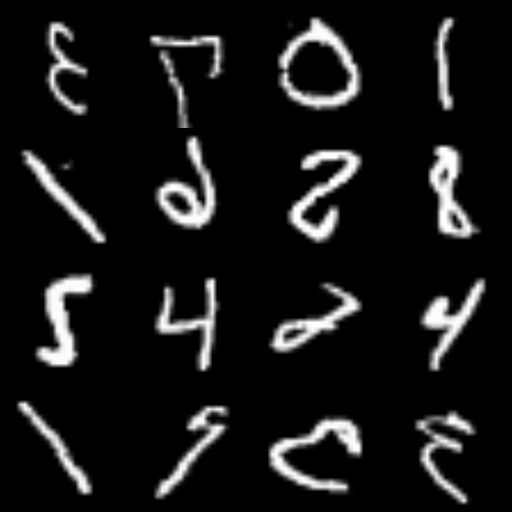

In [ ]:
from IPython.display import Image
display(Image('/content/eigenai-workshop/utmist-workshop-diffusion/samples/0031.png'))

You can sort of see that the model is able to generate somewhat sensible results. Thought some may look weird its still pretty amazing to see that we are able to train a model from scratch on MNIST that can replicate the photos that look similar to the ones in our dataset!

# **Section 9: Final Remarks**:

We've covered a lot of content in this workshop. We hope you enjoyed your time and we hope that you learnt something useful!
Let us know any questions you might have and if you would like to learn more about UTMIST and any upcoming activities, join the UTMIST discord and instagram and stay updated with our newsletter as well!!!